# Simulation Sandbox

The purpose of this notebook is to develop code for simulating results. This exercise serves two purposes:  
1) To conduct preliminary power analyses  
2) To provide data for the production of the analysis pipeline

## DEPENDENCIES 

In [3]:
######################################################################################################################
#                                                  Dependencies                                                      #
######################################################################################################################
import numpy as np # used all around for defining almost any vector/array
import pandas as pd # dataframe used to store data for training
import matplotlib.pyplot as plt # general plotting utility
from scipy.stats import logistic # logistic function used to convery resources invested into performance
from sklearn.linear_model import LogisticRegression # used to fit data to a logistic function
%matplotlib inline 
# plotting within the notebook (otherwise plots may not show up, or may show up as pop-ups)

## FUNCTIONS 

In [4]:
#######################################################################################################################
#                                                   Functions                                                         #
#######################################################################################################################

# Functions which capture the operations performed in this notebook. Usually, I will perform the operation using the code
# within the function first. This will show what I do in the content of a function. On second usage, I will just use a function 
# name instead.

def performance_curve(t,k,t0):
    x = k*(t - t0); # An extremely simplified version of the function we could use to define resource allocation. Ideally, bounded.
    #x = np.clip(x,0,x.max())
    #Ax = A[0]*x + A[1]
    return logistic.cdf(x) # conversion of resource -> performance

def probe(t,y,n,t0,t_pm, method ='randunif'):
    u = np.random.uniform(size=n) # probe random state values (to be compared with latent performance curve)
    
    # probe time points ** This defines the probing scheme, so we may want to have a function arg define
    if method == 'randunif':
        p = np.random.randint(low=t0-t_pm,high=t0+t_pm,size=n)
    elif method == 'intunif':
        p = np.linspace(start=t0-t_pm,stop=t0+t_pm,num=n)
    elif method == 'centunif':
        p = np.random.randint(low=0-t_pm,high=0+t_pm,size=n)
    
    # We will want to bin/digitize our probe times so we can compute averages w/i time bins
    q = np.empty(shape=(n,))
    i = np.digitize(p,t)
    p = t[i]

    for s in range(n):
        q[s] = np.where(t == p[s])[0][0]
    return y[q.astype(int)] > u, p

def check_sim_fit(n=1000,t_start = -500, t_stop = 500, n_t=1001, k=1, t0 = -100, t_pm=100):
    # Create time axis
    t = np.linspace(t_start,t_stop,n_t) # time axis

    # perform sim functions
    y = performance_curve(t=t,t0=t0,k=k)
    draws, times = probe(t=t,y=y,n=n,t0=t0,t_pm=t_pm)

    # format data
    df = pd.DataFrame({'draws':draws,'times':times})

    # fit model
    lr.fit(X=df['times'].values.reshape(-1,1),y=df['draws']) # need to reshape X as 2d since fit expects matrix

    #plot fit, binned means and the actual distribution data was drawn from
    f = df.groupby(by=df['times']).mean().plot();
    fit = lr.predict_proba(t.reshape(-1,1))[:,1] # we want the second column corresponding to P(Correct|Time)
    f.plot(t,fit);
    f.plot(t,y,color='k');
    f.legend(['draws','fit','actual']);
    return f


## **1. specifying the result-generating process** 

 The main expected results which can be seen in the `ExpectedFigures.ipynb` or `mock_figure` photos propose that the primarily result will be a monotonic shift in performance within a window of time.  
The results are:  
1) The easy condition -> no change in performance while the more difficult condition yields monotonic decrease in performance approaching t=0.  
2) The difference between proactive and reactive allocation is a time shift.  
  
What we can do is generate a very simple model of how this process occurs. Let us assume that performance is a function of some latent resource. When a controller allocates resources towards a task, the task may be performed. However, if the controller must allocate resources to two tasks within the same window of time, performance should drop. One way to model this would be to assume that the resources allocated translate to performance via a logistic link. For $x$ resource devoted to the task $y = f(x)$ such that $f(x) = logit(x)$.  
<center>  $y = logit(x)$  
</center>
Next, let us assume that forecast of demand occurs at time t0. When the controller observes this demand, the controller reallocates resources with some rate, k, to accommodate the demand. If there are not enough resources for both tasks, and the controller must reallocate from one domain to another, we can model the performance on the original task as
<center>  $y = 1 - logit(x) = 1 - \dfrac{1}{1+e^{-k(x-t_0)}}$  
</center>

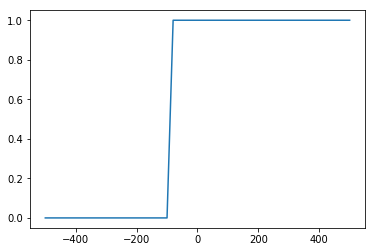

In [5]:
# Define Variables
t = np.linspace(-500,500,1001) # time axis
k = .05 # rate
t0 = -100 # forecast command time

#from sklearn.preprocessing import scale
# Resources over time
x = k*(t - t0); # An extremely simplified version of the function we could use to define resource allocation. Ideally, bounded.
#x = scale(x[:,np.newaxis],with_mean=True,with_std=False)
x = np.clip(x,0,1)

#plot the resources shift
plt.plot(t,x);

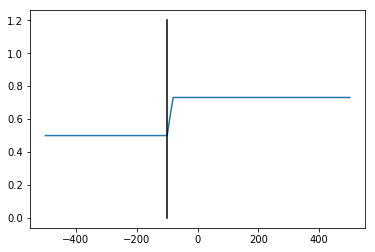

In [6]:
# Next, we want to look at performance on the task which is gaining these resources. We will run x through a logistic function 
# for performance. since this is symmettric, we take 1-logistic to describe the task which is losing these resources

# Convert resources to task performance
y = logistic.cdf(x) # conversion of resource -> performance

# Plot
plt.plot(t,y);
plt.plot([t0,t0],[0,1.2],color='k');

Now, to use this in a simulation, we need to generate an observation from a t0 and a probe (tp) where we sample this curve, and another curve describing another condition in order to try to distinguish the two to some degree of certainty. So, we will make a function to generate datapoints using specified parameters and a sampling scheme.

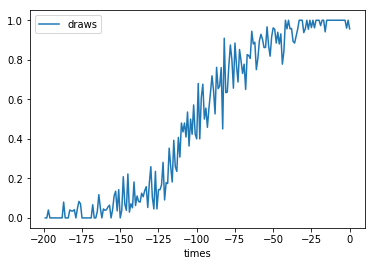

In [62]:
# now we simulate a bunch of draws and plot the means for the values
draws, times = probe(t=t,y=y,n=5000,t0=t0,t_pm=100)
df = pd.DataFrame({'draws':draws,'times':times})
df.groupby(by=df['times']).mean().plot();

In [63]:
# however, this is not likely what we will do, what we are interested in is our estimate of differences between conditions.
# We will fit a sigmoid and estimate the mean
lr = LogisticRegression()
lr.fit(X=df['times'].values.reshape(-1,1),y=df['draws']) # need to reshape X as 2d since fit expects matrix

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [64]:
# Score on training data just to see if it fit that data well
lr.score(X=df['times'].values.reshape(-1,1),y=df['draws'])

0.8632

In [65]:
# resample data and score again
draws2, times2 = probe(t,y,5000,t0,100)
df2 = pd.DataFrame({'draws':draws,'times':times})
lr.score(X=df2['times'].values.reshape(-1,1),y=df2['draws'])

0.8632

This is not really surprising since both train and test contain 5000 uniform samples along the logistic curve.

In [67]:
# the method LogisticRegression.predict_proba() allows us to look at the probability for each class (Incorrect, Correct) for an Input time
lr.predict_proba(-25)

array([[0.02705824, 0.97294176]])

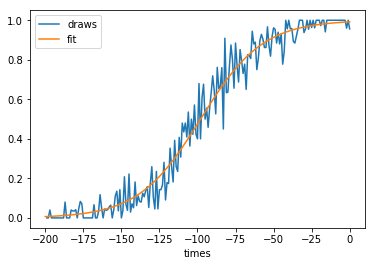

In [69]:
# We can use this to plot the fit
f = df.groupby(by=df['times']).mean().plot();

t = np.linspace(-200,0,201) # discrete time axis
fit = lr.predict_proba(t.reshape(-1,1))[:,1] # we want the second column corresponding to P(Correct|Time)

f.plot(t,fit);
f.legend(['draws','fit']);

Now, this is a sort of best-case scenario. Realistically we will be deealing with a lot more variability: between subjects, within subjects, and likely fewer data points (with 10 subjects and 30 minutes each we would collect 500 data points... 1/10 of what we used for these simulations. If we split this by condition, with 4 conditions we only get 125 per condition). We will want to do simulations under numerous conditions. so, what I will do is create a function for simulating the data and  constructing either a hypothesis test or two fits to the data.

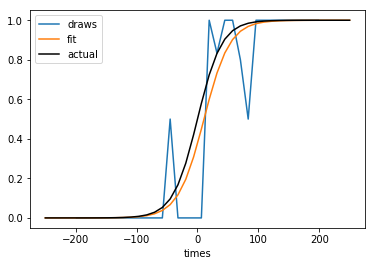

In [70]:
# Params and types of manipulations:
# n
# t start,stop, and n_t
# k
# t0
# t_pm
f= check_sim_fit(n=125, t_start = -250, t_stop = 250, n_t=40, k=.05, t0 = 0, t_pm=200)

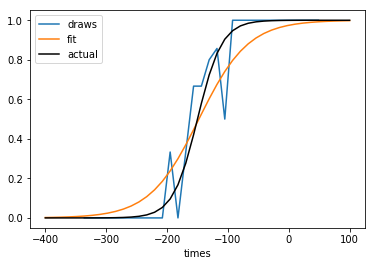

In [71]:
# Now let's try comparing two different simulations:
f2= check_sim_fit(n=125, t_start = -400, t_stop = 100, n_t=40, k=.05, t0 = -150, t_pm=200)